In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
twilight = colormaps["twilight"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
twilight.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
        # "/Users/louis/Data/JWST/amigo_data/calibrators/train_set/",
        # "/Users/louis/Data/JWST/amigo_data/ERS1386/calslope/",
        # "/Users/louis/Data/JWST/amigo_data/COMM1903/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(5)],  # Which sub-pixel position
    **kwargs,
)

_files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")
# _files = ([] +file_fn(FILTER="F480M"))

# Remove duplicates
files, fnames = [], []
for file in _files:
    head = file["PRIMARY"].header
    if head["filename"] not in fnames:
        files.append(file)
    fnames.append(head["filename"])


# fnames = [f["PRIMARY"].header["filename"] for f in files]

files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



1
  TARGPROP: HD-41094
  FILTER: F380M
  NINTS: 1060
  NGROUPS: 11
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 3


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
# import jax.numpy as np

# for file in files:
#     print(file[0].header["FILENAME"])
#     nints = file[0].header["NINTS"]
#     ngroups = file[0].header["NGROUPS"]
#     print(nints)
#     print(ngroups)

#     # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
#     data = np.sum(np.asarray(file["SCI"].data, float), 0)
#     var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)

#     nphot_per_im = np.nansum(data)
#     nphot_tot = nints * nphot_per_im
#     print(nphot_tot * 1e-6)

#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 4, 1)
#     plt.title("Data")
#     plt.imshow(data)
#     plt.colorbar()

#     plt.subplot(1, 4, 2)
#     plt.title("Log10 Data")
#     plt.imshow(np.log10(data))
#     plt.colorbar()

#     plt.subplot(1, 4, 3)
#     plt.title("Variance")
#     # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
#     plt.imshow(var)
#     plt.colorbar()

#     plt.subplot(1, 4, 4)
#     plt.title("Log10 Variance")
#     # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
#     plt.imshow(np.log10(var))
#     plt.colorbar()
#     plt.show()

#     # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
#     psf_est = np.asarray(file["SCI"].data, float)[0]
#     # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)
#     zpoint = np.asarray(file["ZPOINT"].data, float)
#     zpoint_var = np.asarray(file["ZPOINT_VAR"].data, float)

#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 4, 1)
#     plt.title("Bias Estimate")
#     plt.imshow(zpoint - psf_est)
#     plt.colorbar()

#     plt.subplot(1, 4, 2)
#     plt.title("Bias Est Histogram")
#     # plt.imshow(np.log10(zpoint - psf_est))
#     plt.hist((zpoint - psf_est).flatten(), bins=50)

#     plt.subplot(1, 4, 3)
#     plt.title("Zero-Point Variance")
#     # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
#     plt.imshow(zpoint_var)
#     plt.colorbar()

#     plt.subplot(1, 4, 4)
#     plt.title("Log10 Zero-Point Variance")
#     # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
#     plt.imshow(np.log10(zpoint_var))
#     plt.colorbar()
#     plt.show()

In [5]:
import jax.numpy as np
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import PointFit

oversample = 4
optics = AMIOptics(radial_orders=4, oversize=1.1, oversample=oversample)
detector = LinearDetectorModel(oversample=oversample)
ramp_model = PolyNonLin(oversample=oversample)
read_model = ReadModel()

# Prep the model
fit = PointFit()
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, fit_one_on_fs=False)

# Add the binary parameters
model = AmigoModel(
    files, params, optics=optics, detector=detector, ramp=ramp_model, read=read_model
)

## Model and look at splodges, mask 

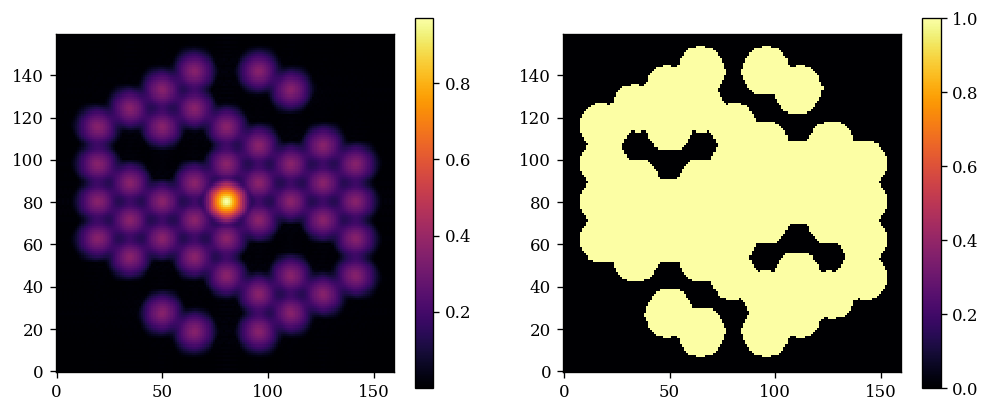

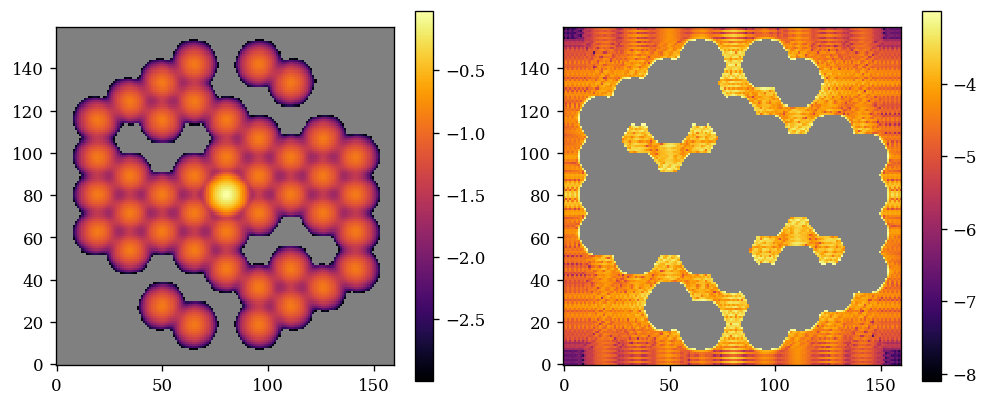

In [6]:
from jax import vmap
import interpax as ipx
import dLux.utils as dlu
from amigo.interferometry import to_uv, from_uv

# Create the splodges
uv_pad = 2
exp = exposures[0]
psfs = fit.model_wfs(model, exp).psf
padded = vmap(lambda x: dlu.resize(x, uv_pad * psfs.shape[-1]))(psfs)
npix_in = padded.shape[-1]

# Crop the splodges
# npix_out = 156
npix_out = 160
full_splodges = vmap(to_uv)(padded).sum(0)
splodges = np.abs(dlu.resize(full_splodges, npix_out))

# Mask outside the OTF region - Shouldn't need to be done in practice
mask = splodges > 1e-3


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# plt.imshow(np.abs(splodges[0]) ** 0.25)
plt.imshow(splodges ** 0.5)
# plt.imshow(np.abs(splodges[0]))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.colorbar()
plt.show()

# mask = np.abs(splodges[0]) > 1e-6
inner = np.where(mask, splodges, np.nan)
outer = np.where(~mask, splodges, np.nan)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(inner), cmap=inferno)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(outer), cmap=inferno)
plt.colorbar()
plt.show()

## Find control points (knots) to match visibility coordinates

In [7]:
import jax.random as jr
from amigo.interferometry import get_baselines_and_inds, osamp_freqs


# Make interpolator of the visibilities on the OTF coordinates
cen_holes = optics.holes - optics.holes.mean(0)[None, :]
# cen_holes = optics.holes
hbls, inds = get_baselines_and_inds(cen_holes)
bls = np.concatenate([np.zeros((1, 2)), hbls, -hbls]).T

x_pts, y_pts = 9, 15
pad_x = 1
pad_y = 2
nx, ny = x_pts + 2 * pad_x, y_pts + 2 * pad_x
dx, dy = 2 / (x_pts - 1), 2 / (y_pts - 1)
xs = bls.max() * np.linspace(-(1 + dx), 1 + dx, x_pts + 2)
ys = bls.max() * np.linspace(-(1 + dy), 1 + dy, y_pts + 2)
x_pts, y_pts = len(xs), len(ys)

# Define visibility coords
wavels, weights = model.filters[exp.filter]
lam = ((wavels * weights).sum() / weights.sum()).mean()
dx = dlu.arcsec2rad(optics.psf_pixel_scale) / (optics.oversample * lam)

crop_to = lambda arr, npix: arr[(len(arr) - npix) // 2 : (len(arr) + npix) // 2]
u_coords = crop_to(osamp_freqs(full_splodges.shape[-1], dx), npix_out)

def nearest_fn(pt, coords):
    dist = np.hypot(coords[0] - pt[0], coords[1] + pt[1])
    return dist == dist.min()


knots = np.array(np.meshgrid(xs, ys))
is_near = vmap(nearest_fn, (0, None))(hbls, knots)
inds = np.array(np.where(is_near))[1:]
bls_pts = np.array([xs[inds[1]], ys[inds[0]]])


#
print(f"{nx * ny} control points\t{4 * nx * ny} parameters")

187 control points	748 parameters


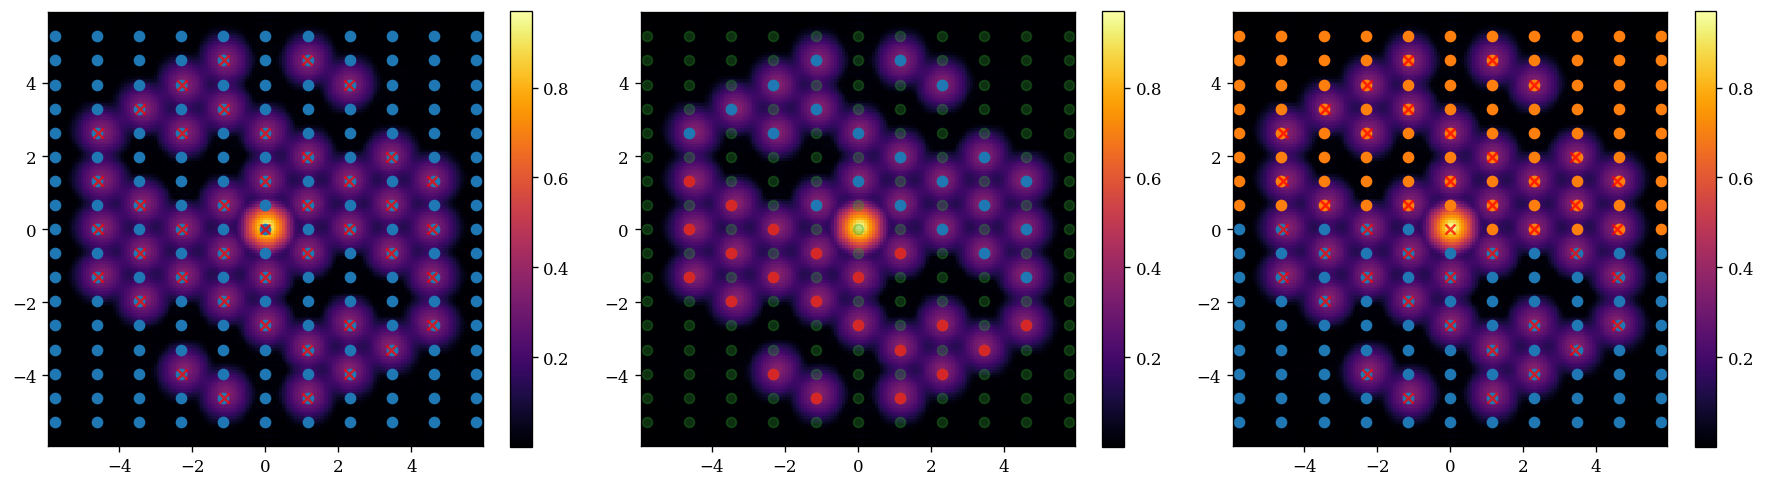

In [8]:
coords = np.array(np.meshgrid(xs, ys))
flat_coords = coords.reshape(2, -1).T
flat_coords = np.round(flat_coords, decimals=3)


matches = []
for i in range(len(flat_coords)):
    # for i in range(2):
    c1 = flat_coords[i]
    for j in range(len(flat_coords)):
        c2 = flat_coords[j]
        if (c1 == -c2).all():
            matches.append((i, j))

matches = np.array(matches)

xs_in = []
inv_xs = []
ys_in = []
inv_ys = []
for i in range(len(matches) // 2):
    j, k = matches[i]
    xs_in.append(flat_coords[j, 0])
    inv_xs.append(flat_coords[k, 0])
    ys_in.append(flat_coords[j, 1])
    inv_ys.append(flat_coords[k, 1])


plt.figure(figsize=(15, 4))
ext = u_coords.max()

plt.subplot(1, 3, 1)
plt.scatter(*np.meshgrid(xs, ys))
plt.scatter(bls[0], bls[1], alpha=0.75, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(*np.meshgrid(xs, ys), alpha=0.3, c="tab:green")
plt.scatter(bls_pts[0], -bls_pts[1], c="tab:blue")
plt.scatter(-bls_pts[0], bls_pts[1], c="tab:red")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(xs_in, ys_in)
plt.scatter(inv_xs, inv_ys)
plt.scatter(bls[0], bls[1], alpha=0.75, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

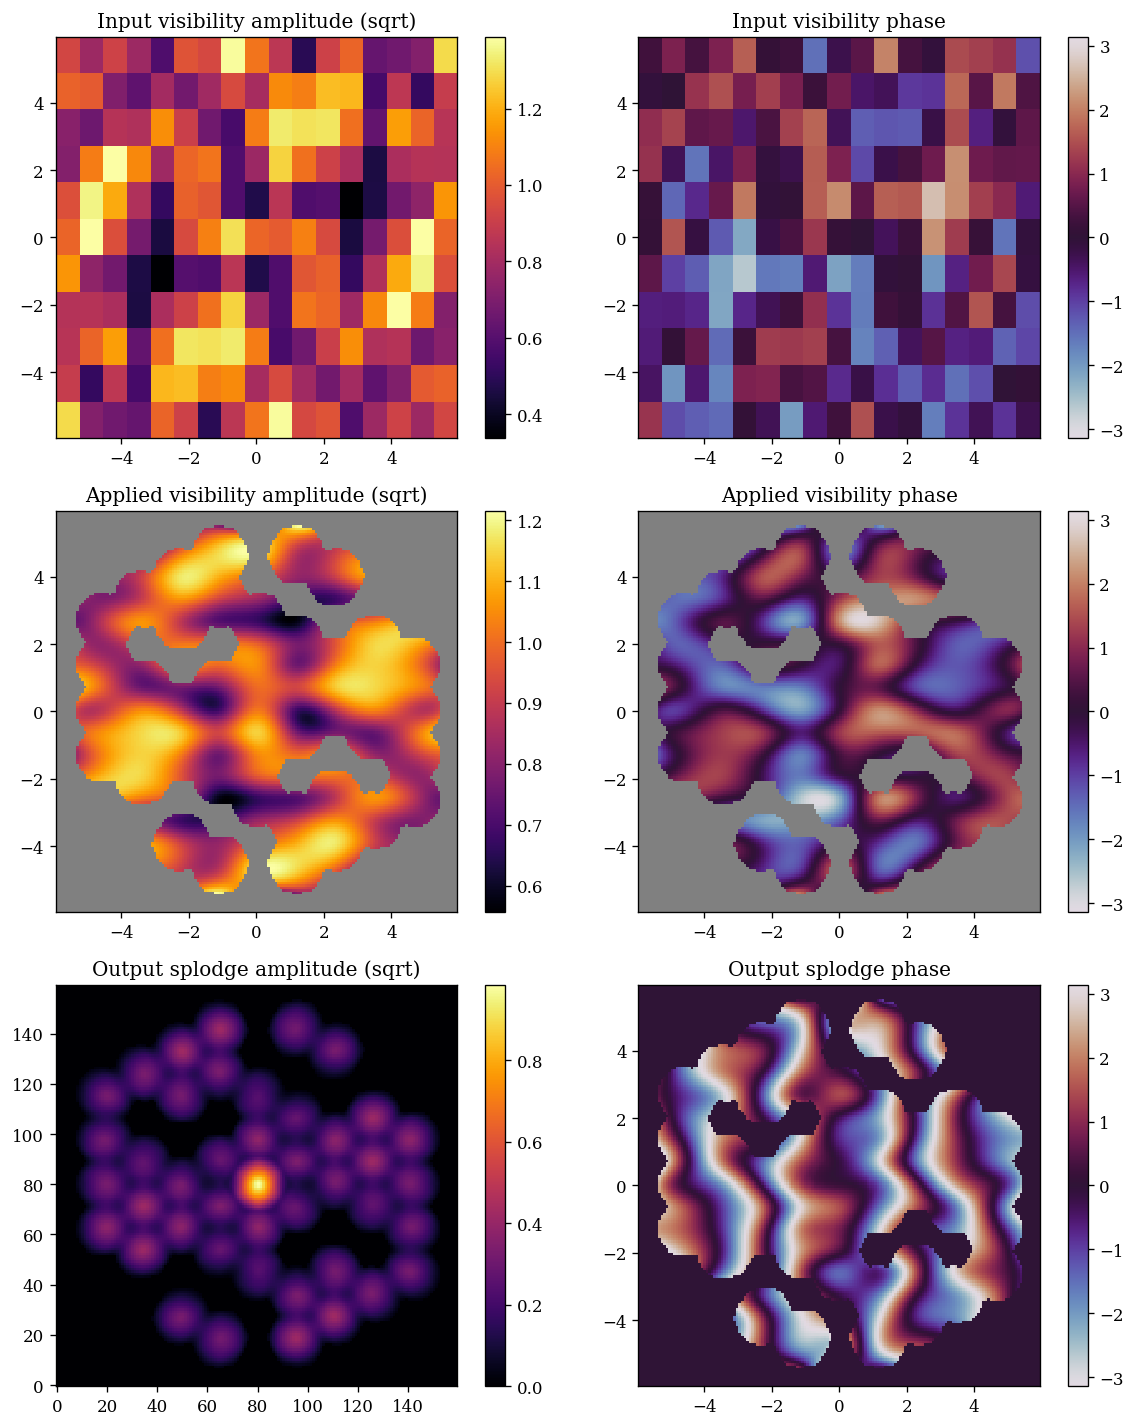

In [9]:
# Smoothing gaussian
def gaussian(sigma, nx, ny):
    xs, ys = np.linspace(-1, 1, nx), np.linspace(-1, 1, ny)
    y, x = np.meshgrid(xs, ys)
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))

kern = gaussian(0.2, 7, 7)

kern = gaussian(0.2, 7, 7)
kern /= kern.sum()
uv_coords = np.meshgrid(u_coords, u_coords)

# Get vis amplitude values
amp_points = 1 + 0.5 * jr.normal(jr.PRNGKey(2), (nx + 4, ny + 4))
convd_amp = jax.scipy.signal.convolve(amp_points, kern, mode="same")[2:-2, 2:-2]
convd_amp = np.maximum(convd_amp, 1e-6)

# Get vis phase values
pha_points = 2 * jr.normal(jr.PRNGKey(2), (nx + 4, ny + 4))
convd_pha = jax.scipy.signal.convolve(pha_points, kern, mode="same")[2:-2, 2:-2]

# Construct input vis map
conv_vis = convd_amp * np.exp(1j * convd_pha)
flat_conv_vis = conv_vis.reshape(-1).T

# Get non redundant set of index conjugate pairs
inv_ind = np.array([np.arange(flat_conv_vis.size), np.arange(flat_conv_vis.size)[::-1]]).T
inv_ind = inv_ind[: len(inv_ind) // 2]

# Apply conjuagte
flat_conv_vis = flat_conv_vis.at[inv_ind[:, 1]].set(flat_conv_vis[inv_ind[:, 0]].conj())
flat_conv_vis = flat_conv_vis.at[1 + len(matches) // 2].set(1 * np.exp(1j * 0))
vis_pts = flat_conv_vis.reshape(conv_vis.shape)

# Get the amplitude map
amp_interper = ipx.Interpolator2D(xs, ys, np.abs(vis_pts), method="cubic2", extrap=True)
amp_interp = lambda xs, ys: amp_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)
amp_map = np.maximum(amp_interp(*uv_coords), 0)

# Get the phase map
pha_interper = ipx.Interpolator2D(xs, ys, np.angle(vis_pts), method="cubic2", extrap=True)
pha_interp = lambda xs, ys: pha_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)
phase_map = pha_interp(*uv_coords)

# Get the applied visibilities map
vis_map = amp_map * np.exp(1j * phase_map)

# Create the splodges
uv_pad = 2
exp = exposures[0]
psfs = fit.model_wfs(model, exp).psf
padded = vmap(lambda x: dlu.resize(x, uv_pad * psfs.shape[-1]))(psfs)
npix_in = padded.shape[-1]

# Crop the splodges
full_splodges = vmap(to_uv)(padded).sum(0)
cplx_splodges = dlu.resize(full_splodges, npix_out)

cplx_applied = vis_map * cplx_splodges
applied_amp = np.abs(cplx_applied)
applied_pha = np.angle(cplx_applied)

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.title("Input visibility amplitude (sqrt)")
plt.imshow(np.abs(vis_pts), extent=(-ext, ext, -ext, ext))
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title("Input visibility phase")
plt.imshow(
    np.angle(vis_pts),
    cmap=twilight,
    vmin=-np.pi,
    vmax=np.pi,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("Applied visibility amplitude (sqrt)")
plt.imshow(
    np.where(mask, np.abs(vis_map), np.nan) ** 0.5,
    cmap=inferno,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("Applied visibility phase")
plt.imshow(
    np.where(mask, np.angle(vis_map), np.nan),
    cmap=twilight,
    vmin=-np.pi,
    vmax=np.pi,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title("Output splodge amplitude (sqrt)")
plt.imshow((mask * applied_amp) ** 0.5)
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title("Output splodge phase")
plt.imshow(
    (mask * applied_pha),
    cmap=twilight,
    vmin=-np.pi,
    vmax=np.pi,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.tight_layout()
plt.show()